# ΜΗΧΑΝΙΚΗ ΜΑΘΗΣΗ

2η ΕΡΓΑΣΙΑ CLUSTERING

ΧΑΜΑΛΙΔΗΣ ΒΑΣΙΛΗΣ 

iis22183

ΤΜΗΜΑ ΕΦΑΡΜΟΣΜΕΝΗΣ ΠΛΗΡΟΦΟΡΙΚΗΣ

In [1]:
# Import libraries
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import cluster
import seaborn as sns
# Pandas Dataframe
import pandas as pd
# Google TS for ML
import tensorflow as tf
# Dataset
import keras
print("Keras version: " + keras.__version__)
from keras.datasets import fashion_mnist
from tensorflow.keras.datasets import mnist
# Import Autoencoder TS keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
# Import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

2024-11-27 13:02:20.458668: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 13:02:20.490336: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Keras version: 3.4.1


# Data Preporcessing

### Cross Validation

In [2]:
# (1) Import fashion dataser
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# (2) Create subset with a validations set
X_train, X_validate, y_train, y_validate =\
      train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [3]:
# Print the data shape
print("Train shape: \t", X_train.shape)
print("Valid shape: \t" , X_validate.shape)
print("Test shape: \t" , X_test.shape)

Train shape: 	 (54000, 28, 28)
Valid shape: 	 (6000, 28, 28)
Test shape: 	 (10000, 28, 28)


### Data Normalization

In [4]:
# Min Max Scaler function
from sklearn.preprocessing import MinMaxScaler

scalermm = MinMaxScaler()

# Declaring variables types 
def scaler(data: pd.DataFrame) -> np.ndarray:
  data_scaled = data.copy()  # Make a copy of data to keep the structure
  data_scaled = scalermm.fit_transform(data_scaled).astype('float32') # Apply scaling 
  return data_scaled #Return the scaled data

### Image Ploting Functions

In [5]:
#Plot images:
def plot_images(data: pd.DataFrame, num_images: int = 20):
    # Calculate the number of rows and columns needed for the subplot grid
    rows = int(np.sqrt(num_images))  # Calculate rows as square root of num_images
    cols = (num_images + rows - 1) // rows  # Calculate columns (to cover remaining images)

    # Create a subplot grid based on the number of images to display
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12),
                           subplot_kw=dict(xticks=[], yticks=[]))
    
    # Adjust spacing between subplots
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # Loop over the number of images and display them in the subplot grid
    for i, axi in enumerate(ax.flat):
        if i < num_images:
            # Display each image in the grid
            im = axi.imshow(data[i], cmap='binary')
            im.set_clim(0, 16)
        else:
            axi.axis('off')  # Turn off axis for any unused subplots

    plt.show()


In [6]:
def plot_random_images_by_cluster(data: np.ndarray, cluster_labels: np.ndarray, num_images_per_cluster: int = 5, title:str = ""):
    """
    Plots a random selection of images for each cluster.

    Parameters:
    - data (np.ndarray): Image data, where each row corresponds to a flattened image.
    - cluster_labels (np.ndarray): Cluster labels corresponding to each image.
    - num_images_per_cluster (int): Number of random images to display for each cluster.
    """
    unique_clusters = np.unique(cluster_labels)  # Get unique cluster labels
    num_clusters = len(unique_clusters)
    
    # Create a figure for subplots, with subplots equal to (num_clusters x num_images_per_cluster)
    fig, ax = plt.subplots(
        num_clusters, num_images_per_cluster,
        figsize=(num_images_per_cluster * 2, num_clusters * 2),
        subplot_kw=dict(xticks=[], yticks=[])
    )
    
    # Check if ax is 1D or 2D
    if num_clusters == 1:
        ax = np.expand_dims(ax, axis=0)  # Make it 2D for consistency if only one cluster
    
    for row, cluster in enumerate(unique_clusters):
        # Get all images for this cluster
        cluster_data = data[cluster_labels == cluster]
        
        # Randomly sample images from this cluster
        if len(cluster_data) > num_images_per_cluster:
            selected_images = cluster_data[np.random.choice(cluster_data.shape[0], num_images_per_cluster, replace=False)]
        else:
            selected_images = cluster_data  # If fewer images, use all
        
        for col, image in enumerate(selected_images):
            ax[row, col].imshow(image.reshape((28, 28)), cmap='binary')
            ax[row, col].set_title(f"Cluster {cluster}")
            ax[row, col].axis('off')
        
        # Turn off unused axes in the row if not enough images
        for col in range(len(selected_images), num_images_per_cluster):
            ax[row, col].axis('off')
    
    # Adjust layout and spacing
    # plt.tight_layout()

       # Add a title for the whole figure
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to include the title


    plt.show()


In [7]:
def plot_clusters(data: np.ndarray, clusterLabels: np.array):
    fig = plt.figure(figsize=(20,20))
    for clusterIdx in range(10):
        for c, val in enumerate(data.values[clusterLabels == clusterIdx][0:10]):
            fig.add_subplot(10, 10, 10*clusterIdx+c+1)
            plt.imshow(val.reshape((28,28)))
            plt.gray()
            plt.xticks([])
            plt.yticks([])
            plt.xlabel('?? ?? ??')
            plt.ylabel('Cluster: '+str(clusterIdx))
            plt.show()



In [8]:
def reshaper_1d(data: np.ndarray) -> np.ndarray:
    rdata = data.copy()
    return rdata.reshape(rdata.shape[0], (rdata.shape[1]*rdata.shape[2]))

### Dimensionality Reduction Models

In [9]:
# (1/3) PCA

# Import PCA
from sklearn.decomposition import PCA

def pca_dm(train: pd.DataFrame, test: pd.DataFrame, display:bool = False) -> np.ndarray:
    pca = PCA(0.99, whiten=True)
    #remember: PCA takes as input a 2d matrix: n paradigms x m features
    pca_created_data = pca.fit_transform(
            train.reshape(train.shape[0],\
                          (train.shape[1] * train.shape[2])))
    
    # Show the transformation if needed
    if display: 
        # Inverse transform to reconstruct train
        inversed_pca_data = pca.inverse_transform(pca_created_data)
        
        # Reshape back to image dimensions
        reshaped_data = inversed_pca_data.reshape(train.shape[0], train.shape[1], train.shape[2])
        
        # Display images
        print("Reshaped images from PCA transform:")
        plot_random_images_by_cluster(reshaped_data, y_train, title="PCA Tranformation")

    ##### Transform the test set only FOR DEMONSTRATION PURPOSES ######
    # Apply PCA to test data
    flattened_test =  reshaper_1d(test) # test.reshape(test.shape[0], -1)
    pca_projected_demo_test_set = pca.transform(flattened_test)

    # Inverse transform to reconstruct TEST
    inversed_pca_demo_test = pca.inverse_transform(pca_projected_demo_test_set)

    # Correct reshaping of inversed PCA data
    reshaped_demo_test = inversed_pca_demo_test.reshape(-1, train.shape[1], train.shape[2])
    ####################################################################

    #apply the existing PCA transform to new train
    pca_projected_data_train_set = pca.transform(\
        train.reshape(train.shape[0], (train.shape[1] * train.shape[2])))

    print('PCA train projected sucessfully.')
    print(pca_projected_data_train_set.shape)

    #apply the existing PCA transform to new test
    pca_projected_data_test_set = pca.transform(
        test.reshape(test.shape[0], (test.shape[1] * test.shape[2]))
                            )
    print('PCA test projected sucessfully.')
    print(pca_projected_data_test_set.shape)

    return pca_projected_data_train_set, pca_projected_data_test_set, reshaped_demo_test

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU

import tensorflow as tf


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only allocate a fraction of GPU memory
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# (2/3) Stacked Autoencoder 
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      # layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),  # Add Dropout to avoid Overfitting
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Don't forget to normalize
def Stacted_Autoencoder(train: np.ndarray, val: np.ndarray, test: np.ndarray, display:bool = False,\
                        latent_dim: int = 64, epochs_: int =10):

  print("Starting Autoencoder . . .")
  
  shape = val.shape[1:]
  autoencoder = Autoencoder(latent_dim, shape)

  autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  autoencoder.fit(train, train,
                epochs = epochs_,
                shuffle = True,
                validation_data=(val, val),
                callbacks=[early_stopping])
  
  print("Encoding data sets . . .")

  # (Απομόνωση του Encoder)
  encoded_train = autoencoder.encoder(train).numpy()

  encoded_test = autoencoder.encoder(test).numpy()
  ## (decode images for demo)
  print("Decoding demo img from test set . . .")
  decoded_test_imgs = autoencoder.decoder(encoded_test).numpy()

  if display:
    plot_random_images_by_cluster(decoded_test_imgs, y_train, title="SAE Tranformation")

  print("Autoencoder finnished . . .")

  return encoded_train, encoded_test, decoded_test_imgs

In [11]:
# !pip install umap-learn

# https://pypi.org/project/umap-learn/

In [12]:
# (3/3) [Personal Choice]
import umap

def umap_reducer(train: np.ndarray, test: np.ndarray):
    """
    UMAP function
    """

    reducer = umap.UMAP(random_state=42, n_jobs= -1)
    reducer.fit(train.data)
    embedding_train = reducer.transform(train.data)

    # Verify that the result of calling transform is
    # idenitical to accessing the embedding_ attribute
    assert(np.all(embedding_train == reducer.embedding_))
    embedding_train.shape

    embedding_test = reducer.transform(test.data)

    ## Project Scatterplot 
    # Generate distinct colors for each class (up to 10)
    color_palette = sns.color_palette("tab10", 10)  # Tab10 gives 10 unique colors
    class_to_color = {cls: color_palette[idx] for idx, cls in enumerate(np.unique(y_train))}

    # UMAP Projection of the data
    plt.figure(figsize=(10, 8))
    plt.scatter(
        embedding_test[:, 0],
        embedding_test[:, 1],
        c=[class_to_color[label] for label in y_test],
        s=10,  # Marker size
        alpha=0.8  # Transparency for better visibility
    )
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of the Test set', fontsize=16)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()

    # Try to inverse the embedding data for DEMONSTRATION PURPOSES
    print("Inverting embedding data . . . ")
    # inv_demo_test = reducer.inverse_transform(embedding_test)
    inv_demo_test = X_test

    print("UMAP completed . . .")
    return embedding_train, embedding_test, inv_demo_test

### Performance Metrics

In [13]:
#define a performance evaluation function
from sklearn import metrics
def performance_score(mdl:str, input_values, cluster_indexes):
    print("\n=== === === ===\nPerformance scores for ", mdl)
    try:
        # (1/4) Calinski–Harabasz index
        ch_score = metrics.calinski_harabasz_score(input_values, cluster_indexes)
        print('>Calinski-Harabasz Index score is {:.2f}'.format(ch_score))
        #print(' ... Higher the value better the clusters.')
    except:
        print(' .. Warning: could not calculate Calinski-Harabasz Index score.')
        ch_score = -999

    try:
        # (2/4) Davies–Bouldin index
        db_score = metrics.davies_bouldin_score(input_values, cluster_indexes)
        print('>Davies-Bouldin Index score is {:.2f}'.format(db_score))
        #print(' ... 0: Lowest possible value, good partitioning.')
    except:
        print(' .. Warning: could not calculate Davies-Bouldin Index score.')
        db_score = -999

    try:
        # (3/4) Silhouette score
        silh_score = metrics.silhouette_score(input_values, cluster_indexes)
        print('>Silhouette Coefficient score is {:.2f}'.format(silh_score))
        #print( ' ... -1: incorrect, 0: overlapping, +1: highly dense clusts.')
    except:
        print(' .. Warning: could not calculate Silhouette Coefficient score.')
        silh_score = -999

        # (4/4) [Personal Choice]

    return silh_score, ch_score, db_score

### Clustering Models

In [14]:
# (1/3) Minibatch kmeans

def miniBatchKMeans_sim(data: np.ndarray, plot_image: np.ndarray):
    mbkm = cluster.MiniBatchKMeans(n_clusters = 10, random_state=64)
    mbkm.fit(data)
    clusterLabels = mbkm.labels_
    
    #performance scores & visualizations
    performance_score("miniBatchKMeans", y_test.reshape(-1, 1), clusterLabels)
    
    if plot_image is not None:
        plot_random_images_by_cluster(plot_image, cluster_labels=clusterLabels,\
             title="miniBatchKMeans Clusters")
    else:
        plot_random_images_by_cluster(data, cluster_labels=clusterLabels,\
             title="miniBatchKMeans Clusters")

In [15]:
# (2/3) DBSCAN
# Cluster the training set

# for [4,6] 11 clusters, for [4,4] 13, [4.5, 4] 16, [4.5, 6] 7
# [3,6] 20, [3, 4] 48, [4.5, 8] 5, [5, 4] 3, [5, 8] 3, [4,8] 7

def dBSCAN_sim(data: np.ndarray, plot_image: np.ndarray, \
    eps_:float= 4.5, min_samples_:int= 4):

    dbscan = cluster.DBSCAN(eps= eps_, min_samples= min_samples_)
    dbscan.fit(data)
    clusterLabels = dbscan.labels_

    #performance scores & visualizations
    performance_score("DBSCAN", y_test.reshape(-1, 1), clusterLabels)
    # in case the data are in ploting condition
    if plot_image is not None:
        plot_random_images_by_cluster(plot_image, cluster_labels=clusterLabels,\
             title="DBSCAN Clusters")
    else:
        plot_random_images_by_cluster(data, cluster_labels=clusterLabels,\
             title="DBSCAN Clusters")



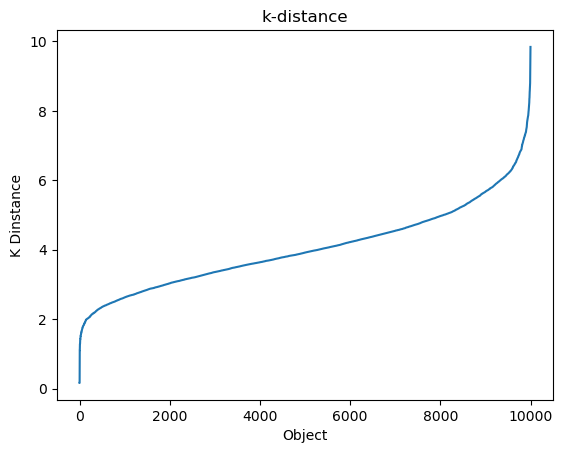

In [16]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

# Trying finding the optimal <eps> hyparameter 
# Paper: https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

X_test_flatten = reshaper_1d(X_test)
X_test_norm = scaler(X_test_flatten)

def nn_eps(data:np.ndarray):
    neighbors = NearestNeighbors(n_neighbors=10)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)

    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.xlabel("Object")
    plt.ylabel("K Dinstance")
    plt.title("k-distance")
    plt.plot(distances)
    plt.show()

nn_eps(X_test_norm)

In [17]:
# (3/3) [Personal choice]

# Model Training

### Sim function for all models

In [18]:
# define cluster function training

'''2. Οι τεχνικές clustering θα εφαρμοστούν στο test set. Είναι σημαντικά μικρότερο σε πλήθος
παρατηρήσεων, άρα θα τρέξει ποιο γρήγορα'''

def cluster_model_sim(test_data: np.ndarray, reshaped_image: np.ndarray= None,\
     eps_dbscan:float= 4.5, min_samples_dbscan:int= 4):
    """
    reshaped_image in case the data are not in ploting shape, if it is leave it intact None
    """

#     miniBatchKMeans_sim(test_data, reshaped_image)

    dBSCAN_sim(test_data, reshaped_image, eps_= eps_dbscan, min_samples_= min_samples_dbscan)

### Normalized method

In this part of code, we use the normalized dataset [0,1]

In [19]:
# Normalize the data
# scaler expects flatten image
X_test_flatten = reshaper_1d(X_test)
X_test_norm = scaler(X_test_flatten)

X_val_flatten = reshaper_1d(X_validate)
X_val_norm = scaler(X_val_flatten)

X_train_flatten = reshaper_1d(X_train)
X_train_norm = scaler(X_train_flatten)

In [ ]:

print("Cluster results for normalized data . . .")

cluster_model_sim(X_test_norm)

### PCA

In [ ]:
# Apply PCA tranformation to Train and Test dataset
pca_train, pca_test, reshaped_back_test = pca_dm(X_train, X_test, True)

In [ ]:
# Trying finding the optimal <eps> hyparameter for this DM method
# Paper: https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf
 
nn_eps(pca_train)

In [ ]:
# Simulate the cluster models
# for min 2 -> 47 clusters

print("Cluster results for PCA transformed data . . .")

cluster_model_sim(pca_test, reshaped_back_test, eps_dbscan= 23, min_samples_dbscan= 2)

### Stacked Autoencoder

In [20]:
enc_train, enc_test, demo_test_sae_img = Stacted_Autoencoder(X_train_norm, X_val_norm, X_train_norm)

nn_eps(enc_train)

Starting Autoencoder . . .
Epoch 1/10


: 

In [ ]:
cluster_model_sim(enc_test, reshaped_image= demo_test_sae_img, eps_dbscan= 0.04, min_samples_dbscan= 7)

### UMAP

In [ ]:
print("Cluster results for UMAP data . . .")

umap_train, umap_test, inv_demo_test = umap_reducer(X_train_norm, X_test_norm)

In [ ]:
nn_eps(umap_train)

In [ ]:
# Run cluster models
cluster_model_sim(umap_test, reshaped_image= inv_demo_test, eps_dbscan= 0.04, min_samples_dbscan= 7)